# gluonts12-end_dates (yearly, deepar)

This notebook is used to check the performance of `deepar` on the yearly subsets of the m4 data with the same end dates. 

In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import gluonts
print(gluonts.__version__)

import mxnet
print(mxnet.__version__)

# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar

0.4.2
1.4.1


INFO:root:Using CPU


In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

## Check datasets

In [5]:
dataname = "m4_weekly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.


**To do:** Transfer the quarterly datasets to the right place: 

- `mv [data] ../../.mxnet/gluon-ts/datasets

In [15]:
dataname = "m4_yearly_end2009"
dataset = get_dataset(dataname, regenerate=False)
len(dataset.train) # 6029

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2009.


6029

In [16]:
dataname = "m4_yearly_end1991"
dataset = utils.get_dataset(dataname, regenerate=False)
len(dataset.train) # 3496

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end1991.


3496

In [17]:
dataname = "m4_yearly_end2004"
dataset = utils.get_dataset(dataname, regenerate=False)
len(dataset.train) # 984

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2004.


984

In [18]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
length train dataset 984
length test dataset 984


In [19]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='12M'),
 'item_id': 'Y93',
 'target': array([6299.2856, 6617.7515, 6646.9556, 6842.242 , 7000.5493, 7203.311 ,
        7294.1323, 7729.0674, 7524.5405, 7373.8843, 6889.815 , 6864.537 ,
        6739.244 , 6831.9272, 6880.068 , 6516.8657, 7248.7617, 7815.169 ,
        8591.859 , 8721.834 , 7833.4243, 7720.185 , 7989.667 , 8207.53  ,
        8696.773 , 8662.692 , 8507.0205, 8166.554 , 8199.917 , 8267.792 ,
        8477.086 , 8176.0806, 8494.96  , 8766.62  , 8753.1875, 8462.25  ,
        7992.9634, 8161.5757, 8084.239 , 8255.591 , 8234.398 , 8303.153 ,
        8173.5044, 8284.113 , 8290.9375, 8055.8843], dtype=float32),
 'feat_static_cat': array([1], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2004/train/m4_yearly_end2004_train.json'), line=1), row=1)}

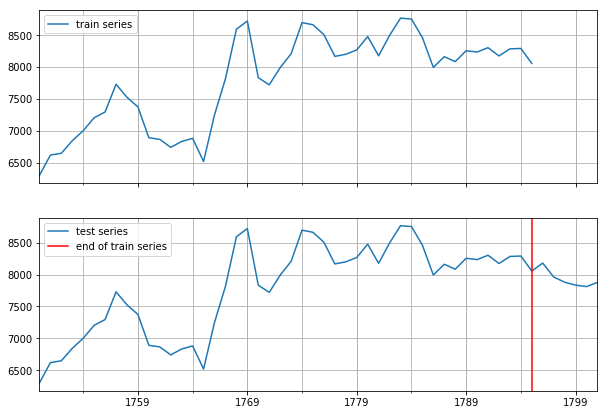

In [20]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [21]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [22]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

## Study 1: `m4_yearly_end2009`

In [24]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end2009", seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2009.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 331173
100%|██████████| 50/50 [00:00<00:00, 58.52it/s, avg_epoch_loss=8.03]
INFO:root:Epoch[0] Elapsed time 0.857 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.034798
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.67it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[1] Elapsed time 0.662 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.697961
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.14it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[2] Elapsed time 0.633 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.803568
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.30it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[3] Elapsed time 0.684 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.536077
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.53it/s, avg_epoch_loss=7.09]
INFO:

100%|██████████| 50/50 [00:00<00:00, 81.70it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[37] Elapsed time 0.613 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.484704
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.35it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[38] Elapsed time 0.631 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.153078
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 87.92it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[39] Elapsed time 0.570 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.043770
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.97it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[40] Elapsed time 0.634 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.506786
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.23it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[41] Elapsed time 0.617 seconds
INFO:roo

100%|██████████| 50/50 [00:00<00:00, 80.73it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[74] Elapsed time 0.621 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.454313
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 84.99it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[75] Elapsed time 0.590 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.221735
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 80.67it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[76] Elapsed time 0.621 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.083406
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 89.55it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[77] Elapsed time 0.559 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.886313
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 79.28it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[78] Elapsed time 0.632 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.935212  0.141887  53.407216            0.144851            0.108962   

   seed  epochs  num_batches  
0    42     100           50  
Seed: 43


100%|██████████| 50/50 [00:00<00:00, 78.81it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 0.636 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.261242
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.42it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[1] Elapsed time 0.615 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.689569
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 87.69it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[2] Elapsed time 0.571 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.885769
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.92it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[3] Elapsed time 0.619 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.544586
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.59it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[4] Elapsed time 0.614 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 80.06it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[37] Elapsed time 0.626 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.545653
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 80.15it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[38] Elapsed time 0.625 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.287209
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 88.80it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[39] Elapsed time 0.564 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.894956
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 80.55it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[40] Elapsed time 0.622 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.503224
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 84.07it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[41] Elapsed time 0.596 seconds
INFO:

INFO:root:Loading parameters from best epoch (53)
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 79.40it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[74] Elapsed time 0.631 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.670535
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 83.34it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[75] Elapsed time 0.601 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.365720
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 81.50it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[76] Elapsed time 0.615 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.211054
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 88.64it/s, avg_epoch_loss=7]
INFO:root:Epoch[77] Elapsed time 0.565 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.998590
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 50

     MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.9961  0.142371  49.178536             0.14598            0.108634    43   

   epochs  num_batches  
0     100           50  
Seed: 44


100%|██████████| 50/50 [00:00<00:00, 74.77it/s, avg_epoch_loss=8]
INFO:root:Epoch[0] Elapsed time 0.670 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.003049
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.15it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[1] Elapsed time 0.642 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.650568
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 84.48it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[2] Elapsed time 0.593 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.803977
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.02it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[3] Elapsed time 0.650 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.475024
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.38it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[4] Elapsed time 0.631 seconds
INFO:root:Epoch[4] Evalua

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.00it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[38] Elapsed time 0.611 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.200266
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.72it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 0.606 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.615903
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 87.31it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[40] Elapsed time 0.574 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.813585
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.34it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[41] Elapsed time 0.616 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.424188
INFO:root:Loading parameters from best epoch (31)
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<0

100%|██████████| 50/50 [00:00<00:00, 83.84it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[74] Elapsed time 0.598 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.759571
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 80.32it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[75] Elapsed time 0.624 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.466737
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 79.04it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[76] Elapsed time 0.634 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.180027
INFO:root:Loading parameters from best epoch (46)
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 87.44it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[77] Elapsed time 0.573 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.759424
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 84.65it/s, avg_epoch_loss

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.276794  0.151739  68.143541            0.156233            0.136073   

   seed  epochs  num_batches  
0    44     100           50  
Seed: 45


100%|██████████| 50/50 [00:00<00:00, 78.28it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[0] Elapsed time 0.640 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.834863
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.32it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[1] Elapsed time 0.624 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.652045
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 87.47it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[2] Elapsed time 0.573 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.767218
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.40it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[3] Elapsed time 0.623 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.492016
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.45it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[4] Elapsed time 0.600 seconds
INFO:root:Epoch[4] Ev

INFO:root:Loading parameters from best epoch (27)
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 81.46it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[38] Elapsed time 0.615 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.175326
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 86.79it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[39] Elapsed time 0.577 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.754866
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 84.51it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[40] Elapsed time 0.593 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.675007
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 81.42it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[41] Elapsed time 0.615 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.584462
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00

100%|██████████| 50/50 [00:00<00:00, 81.94it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[75] Elapsed time 0.612 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.328029
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 80.67it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[76] Elapsed time 0.621 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.992006
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 88.00it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 0.570 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.675648
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 81.24it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[78] Elapsed time 0.617 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.480177
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 81.46it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[79] Elapsed time 0.615 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.967274  0.146717  50.464449            0.147613             0.10446   

   seed  epochs  num_batches  
0    45     100           50  
Seed: 46


100%|██████████| 50/50 [00:00<00:00, 76.80it/s, avg_epoch_loss=8.22]
INFO:root:Epoch[0] Elapsed time 0.653 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.218774
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.59it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[1] Elapsed time 0.622 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.652460
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 85.57it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[2] Elapsed time 0.585 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.828562
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.92it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[3] Elapsed time 0.627 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.459999
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.02it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[4] Elapsed time 0.618 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.23it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[38] Elapsed time 0.640 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.092197
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.94it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[39] Elapsed time 0.611 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.786516
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.29it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[40] Elapsed time 0.624 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.656708
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.70it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[41] Elapsed time 0.645 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.492596
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.46it/s, avg_epoch_loss=6.12]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 80.36it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[75] Elapsed time 0.623 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.384107
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.40it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[76] Elapsed time 0.623 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.919726
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 89.19it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[77] Elapsed time 0.562 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.753714
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.52it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[78] Elapsed time 0.630 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.339723
INFO:root:Loading parameters from best epoch (68)
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 84.08it/s, avg_epoch_loss=6.17]
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.167518  0.150735  58.751611            0.151778            0.117167   

   seed  epochs  num_batches  
0    46     100           50  
Seed: 47


100%|██████████| 50/50 [00:00<00:00, 74.84it/s, avg_epoch_loss=8.05]
INFO:root:Epoch[0] Elapsed time 0.669 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.051547
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.34it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[1] Elapsed time 0.608 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.689152
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 88.01it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[2] Elapsed time 0.569 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.876090
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.88it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[3] Elapsed time 0.620 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.554781
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.42it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[4] Elapsed time 0.608 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.54it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[38] Elapsed time 0.630 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.234109
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 85.69it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[39] Elapsed time 0.585 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.783303
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.35it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[40] Elapsed time 0.624 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.546169
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.60it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[41] Elapsed time 0.614 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.373082
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.63it/s, avg_epoch_loss=6.14]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 82.37it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[75] Elapsed time 0.608 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.139997
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 79.93it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[76] Elapsed time 0.627 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.067769
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 88.06it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[77] Elapsed time 0.569 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.887300
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 79.54it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[78] Elapsed time 0.630 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.368017
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 81.77it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[79] Elapsed time 0.614 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.291659  0.152379  64.053562            0.154522            0.127579   

   seed  epochs  num_batches  
0    47     100           50  
Seed: 48


100%|██████████| 50/50 [00:00<00:00, 73.60it/s, avg_epoch_loss=8.24]
INFO:root:Epoch[0] Elapsed time 0.681 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.235501
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.23it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[1] Elapsed time 0.609 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.708679
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 86.52it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[2] Elapsed time 0.579 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.872670
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.59it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[3] Elapsed time 0.615 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.570630
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.22it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[4] Elapsed time 0.602 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.03it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[38] Elapsed time 0.618 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.209619
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.48it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[39] Elapsed time 0.600 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.667068
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 85.04it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[40] Elapsed time 0.589 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.725312
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.71it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[41] Elapsed time 0.621 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.419022
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.38it/s, avg_epoch_loss=6.15]
INFO:root:Ep

INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 79.54it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[75] Elapsed time 0.630 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.389826
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 80.09it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[76] Elapsed time 0.626 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.991396
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 87.69it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[77] Elapsed time 0.573 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.705498
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 79.24it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[78] Elapsed time 0.632 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.514103
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 81.67it/s, avg_epoch_loss=6.27]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.975243  0.143361  56.240007            0.146303            0.115358   

   seed  epochs  num_batches  
0    48     100           50  
Seed: 49


100%|██████████| 50/50 [00:00<00:00, 78.61it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 0.637 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.257821
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.04it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[1] Elapsed time 0.618 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.843355
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 88.76it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[2] Elapsed time 0.564 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.866332
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.28it/s, avg_epoch_loss=7.56]
INFO:root:Epoch[3] Elapsed time 0.626 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.560377
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.09it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[4] Elapsed time 0.618 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.56it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[38] Elapsed time 0.622 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.182497
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 88.42it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[39] Elapsed time 0.567 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.775229
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.76it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[40] Elapsed time 0.613 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.634430
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.19it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[41] Elapsed time 0.610 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.454600
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.39it/s, avg_epoch_loss=6.09]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 84.04it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[75] Elapsed time 0.596 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.153006
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 82.23it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[76] Elapsed time 0.610 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.962140
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 89.23it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[77] Elapsed time 0.562 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.865181
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 81.76it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[78] Elapsed time 0.613 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.351678
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 82.92it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[79] Elapsed time 0.606 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.000285  0.146519  50.519584            0.147625            0.107404   

   seed  epochs  num_batches  
0    49     100           50  
Seed: 50


100%|██████████| 50/50 [00:00<00:00, 77.01it/s, avg_epoch_loss=8.25]
INFO:root:Epoch[0] Elapsed time 0.651 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.248042
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.47it/s, avg_epoch_loss=7.85]
INFO:root:Epoch[1] Elapsed time 0.615 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.849528
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 86.74it/s, avg_epoch_loss=7.91]
INFO:root:Epoch[2] Elapsed time 0.578 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.914329
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.43it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[3] Elapsed time 0.624 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.587442
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.58it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[4] Elapsed time 0.607 seconds
INFO:root:Epoch[4] Ev

INFO:root:Loading parameters from best epoch (27)
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 83.95it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[38] Elapsed time 0.597 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.172033
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 83.52it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[39] Elapsed time 0.600 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.752412
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 84.52it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[40] Elapsed time 0.593 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.852738
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 80.34it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[41] Elapsed time 0.624 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.536533
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00

100%|██████████| 50/50 [00:00<00:00, 83.11it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[74] Elapsed time 0.603 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.635565
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 80.37it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[75] Elapsed time 0.623 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.497105
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 81.63it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[76] Elapsed time 0.614 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.092870
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 88.68it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[77] Elapsed time 0.565 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.774455
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 81.43it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[78] Elapsed time 0.615 secon

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.124909  0.147106  58.695971            0.149696            0.121502   

   seed  epochs  num_batches  
0    50     100           50  
Seed: 51


100%|██████████| 50/50 [00:00<00:00, 78.87it/s, avg_epoch_loss=8.34]
INFO:root:Epoch[0] Elapsed time 0.636 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.339722
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.77it/s, avg_epoch_loss=7.74]
INFO:root:Epoch[1] Elapsed time 0.620 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.741614
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 87.83it/s, avg_epoch_loss=7.85]
INFO:root:Epoch[2] Elapsed time 0.570 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.851776
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.59it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[3] Elapsed time 0.630 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.606365
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 75.15it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[4] Elapsed time 0.667 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 80.75it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[37] Elapsed time 0.620 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.497746
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 81.83it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[38] Elapsed time 0.612 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.224079
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 85.55it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[39] Elapsed time 0.586 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.767741
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 82.62it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[40] Elapsed time 0.606 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.703728
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 80.04it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[41] Elapsed time 0.626 seconds
INFO:ro

100%|██████████| 50/50 [00:00<00:00, 83.93it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 0.597 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.581690
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 79.42it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[75] Elapsed time 0.631 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.354887
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 80.08it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[76] Elapsed time 0.626 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.076063
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 87.63it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[77] Elapsed time 0.572 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.691156
INFO:root:Loading parameters from best epoch (57)
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 79.31it/s, avg_epoch_loss=6.

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.206371  0.149994  56.244502             0.15314             0.11547   

   seed  epochs  num_batches  
0    51     100           50  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,2.935212,0.141887,53.407216,0.144851,0.108962,42,100,50
0,2.996100,0.142371,49.178536,0.145980,0.108634,43,100,50
0,3.276794,0.151739,68.143541,0.156233,0.136073,44,100,50
0,2.967274,0.146717,50.464449,0.147613,0.104460,45,100,50
0,3.167518,0.150735,58.751611,0.151778,0.117167,46,100,50
0,3.291659,0.152379,64.053562,0.154522,0.127579,47,100,50
0,2.975243,0.143361,56.240007,0.146303,0.115358,48,100,50
0,3.000285,0.146519,50.519584,0.147625,0.107404,49,100,50
0,3.124909,0.147106,58.695971,0.149696,0.121502,50,100,50
0,3.206371,0.149994,56.244502,0.153140,0.115470,51,100,50


In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end2009", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_end2009.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 331173


Seed: 42


100%|██████████| 100/100 [00:01<00:00, 79.41it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 1.261 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.866379
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 82.94it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[1] Elapsed time 1.207 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.669822
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.74it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[2] Elapsed time 1.181 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.295989
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 82.61it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[3] Elapsed time 1.212 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.237762
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 85.98it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[4] Elapsed time 1.164 seconds
INFO:root:Epo

100%|██████████| 100/100 [00:01<00:00, 82.18it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[37] Elapsed time 1.218 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.277854
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 85.24it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[38] Elapsed time 1.175 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.492724
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 80.99it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[39] Elapsed time 1.236 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.200095
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.50it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[40] Elapsed time 1.199 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.541684
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.63it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[41] Elapsed time 1.226 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 84.85it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[74] Elapsed time 1.180 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.415863
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 80.71it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[75] Elapsed time 1.240 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.074605
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 84.32it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[76] Elapsed time 1.187 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.413033
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 81.30it/s, avg_epoch_loss=6]
INFO:root:Epoch[77] Elapsed time 1.231 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.000582
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 

INFO:root:Loading parameters from best epoch (79)
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.39it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[110] Elapsed time 1.186 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.406614
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.30it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[111] Elapsed time 1.247 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.043386
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.99it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[112] Elapsed time 1.192 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.441101
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.85it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[113] Elapsed time 1.223 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.951787
INFO:root:Epoch[114] Learning rate is 5e-05
100%|█████

100%|██████████| 100/100 [00:01<00:00, 83.91it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[146] Elapsed time 1.193 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.396283
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.33it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[147] Elapsed time 1.231 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.932145
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.01it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[148] Elapsed time 1.192 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.483559
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.04it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[149] Elapsed time 1.235 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.005349
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.32it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.59it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[183] Elapsed time 1.212 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.061650
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.47it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[184] Elapsed time 1.214 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.350269
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.16it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[185] Elapsed time 1.190 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.155341
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.37it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[186] Elapsed time 1.215 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.147521
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.70it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.975191  0.143923  48.748319            0.144895            0.099175   

   seed  epochs  num_batches  
0    42     200          100  
Seed: 43


100%|██████████| 100/100 [00:01<00:00, 80.23it/s, avg_epoch_loss=7.98]
INFO:root:Epoch[0] Elapsed time 1.248 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.975405
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.63it/s, avg_epoch_loss=7.72]
INFO:root:Epoch[1] Elapsed time 1.197 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.715178
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.32it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 1.201 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.206525
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 82.33it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 1.216 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.230562
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.17it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[4] Elapsed time 1.190 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 74.14it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[37] Elapsed time 1.350 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.275970
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 77.24it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[38] Elapsed time 1.296 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.382786
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 73.51it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[39] Elapsed time 1.362 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.139225
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 76.67it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[40] Elapsed time 1.306 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.558986
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 74.41it/s, avg_epoch_loss=

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.125791
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 84.74it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[74] Elapsed time 1.182 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.456016
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 80.82it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[75] Elapsed time 1.238 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.061913
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 84.62it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 1.183 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.506345
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 79.36it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[77] Elapsed time 1.261 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.05

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.041109
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.67it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[110] Elapsed time 1.182 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.382365
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.52it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[111] Elapsed time 1.228 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.005545
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.64it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[112] Elapsed time 1.183 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.471623
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.51it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[113] Elapsed time 1.228 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.067456
INFO:root:Epoch[114] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 84.72it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[146] Elapsed time 1.181 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.477353
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.21it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[147] Elapsed time 1.248 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.030298
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.75it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[148] Elapsed time 1.181 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.443332
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.75it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[149] Elapsed time 1.210 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.950635
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.53it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.44it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[183] Elapsed time 1.229 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.923650
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.03it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[184] Elapsed time 1.191 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.411604
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.28it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[185] Elapsed time 1.217 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.011613
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.75it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[186] Elapsed time 1.195 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.379753
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.14it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.951434  0.146575  49.121416            0.148169            0.102291   

   seed  epochs  num_batches  
0    43     200          100  
Seed: 44


100%|██████████| 100/100 [00:01<00:00, 80.15it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[0] Elapsed time 1.249 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.826808
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.36it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[1] Elapsed time 1.201 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.639501
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.32it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[2] Elapsed time 1.202 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.227935
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.17it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 1.204 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.268541
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.57it/s, avg_epoch_loss=7]
INFO:root:Epoch[4] Elapsed time 1.198 seconds
INFO:root:Epoc

100%|██████████| 100/100 [00:01<00:00, 83.76it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[37] Elapsed time 1.196 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.542826
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 84.03it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[38] Elapsed time 1.191 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.369399
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 82.57it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[39] Elapsed time 1.212 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.508401
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 84.82it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[40] Elapsed time 1.180 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.472953
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 82.37it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[41] Elapsed time 1.215 se

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 84.89it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[74] Elapsed time 1.179 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.367898
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 82.13it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[75] Elapsed time 1.219 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.099674
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 84.66it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[76] Elapsed time 1.183 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.467055
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 81.67it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[77] Elapsed time 1.226 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.110567
INFO:root:Epoch[78] Learning rate is 0.000125
100%|███████

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.81it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[110] Elapsed time 1.320 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.495007
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.91it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[111] Elapsed time 1.336 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.106953
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.72it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[112] Elapsed time 1.196 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.462349
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.65it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[113] Elapsed time 1.226 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.008178
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.69it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.506484
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.09it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[147] Elapsed time 1.219 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.055335
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.91it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 1.193 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.462092
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.04it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[149] Elapsed time 1.192 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.251256
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.21it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[150] Elapsed time 1.218 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.318470
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 85.83it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[183] Elapsed time 1.166 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.362238
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.38it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[184] Elapsed time 1.230 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.069437
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.72it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[185] Elapsed time 1.196 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.376741
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.26it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[186] Elapsed time 1.232 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.010683
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 85.15it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[187] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.974643  0.145789  49.326125            0.146913            0.102719   

   seed  epochs  num_batches  
0    44     200          100  
Seed: 45


100%|██████████| 100/100 [00:01<00:00, 79.99it/s, avg_epoch_loss=7.74]
INFO:root:Epoch[0] Elapsed time 1.252 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.743454
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.94it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 1.192 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.629617
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.01it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 1.192 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.207632
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.11it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 1.204 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.225625
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.40it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[4] Elapsed time 1.186 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 83.36it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[37] Elapsed time 1.201 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.452015
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.00it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[38] Elapsed time 1.192 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.296084
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 82.56it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[39] Elapsed time 1.212 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.372167
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.38it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[40] Elapsed time 1.186 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.374067
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.48it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[41] Elapsed time 1.228 seconds

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.153987
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 83.71it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[74] Elapsed time 1.196 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.316812
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 81.55it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[75] Elapsed time 1.228 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.055955
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 85.14it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[76] Elapsed time 1.176 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.475076
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 81.98it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[77] Elapsed time 1.221 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.0422

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.026030
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.38it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[110] Elapsed time 1.186 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.480393
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.99it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[111] Elapsed time 1.236 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.024740
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 85.60it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[112] Elapsed time 1.169 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.423880
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.78it/s, avg_epoch_loss=6]
INFO:root:Epoch[113] Elapsed time 1.239 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.999465
INFO:root:Epoch[114] Learning rate is 5e-05
10

100%|██████████| 100/100 [00:01<00:00, 84.69it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[146] Elapsed time 1.182 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.419750
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.80it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[147] Elapsed time 1.239 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.015553
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.38it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[148] Elapsed time 1.186 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.451899
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.12it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[149] Elapsed time 1.249 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.946539
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 85.47it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.15it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[183] Elapsed time 1.233 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.956171
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.62it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[184] Elapsed time 1.197 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.421430
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.99it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[185] Elapsed time 1.206 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.058254
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.27it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[186] Elapsed time 1.217 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.327116
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.18it/s, avg_epoch_

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.929438  0.144854  49.83797            0.145673             0.10118    45   

   epochs  num_batches  
0     200          100  
Seed: 46


100%|██████████| 100/100 [00:01<00:00, 80.19it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[0] Elapsed time 1.248 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.935617
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.20it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[1] Elapsed time 1.203 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.644280
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.41it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 1.200 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.206219
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.56it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 1.198 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.269018
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.60it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[4] Elapsed time 1.198 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 81.67it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[37] Elapsed time 1.226 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.432072
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.55it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[38] Elapsed time 1.184 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.336720
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.29it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[39] Elapsed time 1.231 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.267354
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.21it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[40] Elapsed time 1.189 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.378794
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 80.79it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[41] Elapsed time 1.239 second

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.130330
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 84.17it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[74] Elapsed time 1.189 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.355546
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 81.67it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[75] Elapsed time 1.226 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.095440
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 84.74it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[76] Elapsed time 1.181 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.443604
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 81.67it/s, avg_epoch_loss=6]
INFO:root:Epoch[77] Elapsed time 1.226 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.996964

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.93it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[110] Elapsed time 1.179 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.415527
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.04it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[111] Elapsed time 1.235 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.024182
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.35it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[112] Elapsed time 1.187 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.487956
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.29it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[113] Elapsed time 1.247 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.044331
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.15it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.475332
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 77.60it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[147] Elapsed time 1.294 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.965518
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.47it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[148] Elapsed time 1.199 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.437853
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.30it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[149] Elapsed time 1.202 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.132443
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.57it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[150] Elapsed time 1.212 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.311192
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 84.22it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[183] Elapsed time 1.189 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.233946
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.25it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[184] Elapsed time 1.233 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.115996
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.20it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[185] Elapsed time 1.203 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.295237
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.61it/s, avg_epoch_loss=6]
INFO:root:Epoch[186] Elapsed time 1.242 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.999383
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.50it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[187] Elapsed time 1.1

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.039298  0.147663  51.406661            0.148887            0.105117   

   seed  epochs  num_batches  
0    46     200          100  
Seed: 47


100%|██████████| 100/100 [00:01<00:00, 78.67it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 1.273 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.870349
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.63it/s, avg_epoch_loss=7.72]
INFO:root:Epoch[1] Elapsed time 1.197 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.715436
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.44it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 1.200 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.263019
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.61it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[3] Elapsed time 1.197 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.349292
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.22it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[4] Elapsed time 1.203 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 80.95it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[37] Elapsed time 1.236 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.261759
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.52it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[38] Elapsed time 1.184 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.454621
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.67it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[39] Elapsed time 1.226 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.215791
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.37it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[40] Elapsed time 1.187 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.541602
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 79.71it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:01<00:00, 82.35it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[73] Elapsed time 1.216 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.039080
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 84.89it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 1.179 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.531783
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 81.54it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[75] Elapsed time 1.228 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.042963
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 84.62it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[76] Elapsed time 1.183 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.498271
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 80.72it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[77] Elapsed time 1

100%|██████████| 100/100 [00:01<00:00, 81.80it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[109] Elapsed time 1.224 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.069203
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.57it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[110] Elapsed time 1.184 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.521951
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.31it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[111] Elapsed time 1.216 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.056287
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 85.00it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[112] Elapsed time 1.178 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.468874
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.29it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[113] Elapsed time

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 76.41it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[146] Elapsed time 1.310 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.511078
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.52it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[147] Elapsed time 1.343 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.036559
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.95it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 1.318 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.455648
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 75.35it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[149] Elapsed time 1.329 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.089617
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 74.76it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.252016
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.48it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[183] Elapsed time 1.185 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.280134
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.76it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[184] Elapsed time 1.224 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.094965
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.10it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[185] Elapsed time 1.190 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.245134
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.38it/s, avg_epoch_loss=6]
INFO:root:Epoch[186] Elapsed time 1.230 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.001851
INFO:root:Epoch[187] Learning rate is 5e-05
10

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.127158  0.148483  54.248744            0.150475            0.109453   

   seed  epochs  num_batches  
0    47     200          100  
Seed: 48


100%|██████████| 100/100 [00:01<00:00, 80.31it/s, avg_epoch_loss=7.97]
INFO:root:Epoch[0] Elapsed time 1.247 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.972090
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.87it/s, avg_epoch_loss=7.72]
INFO:root:Epoch[1] Elapsed time 1.194 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.721650
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.57it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[2] Elapsed time 1.184 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.279043
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.17it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 1.190 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.272634
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.78it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[4] Elapsed time 1.181 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 83.07it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[37] Elapsed time 1.205 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.434496
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 85.18it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[38] Elapsed time 1.175 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.299001
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 82.25it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[39] Elapsed time 1.217 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.353316
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.80it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[40] Elapsed time 1.180 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.363321
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 80.93it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:01<00:00, 82.42it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[73] Elapsed time 1.214 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.232596
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 83.85it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[74] Elapsed time 1.194 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.355362
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 81.22it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[75] Elapsed time 1.232 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.102865
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 84.96it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[76] Elapsed time 1.178 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.467222
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 81.48it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[77] Elapsed time 1

100%|██████████| 100/100 [00:01<00:00, 80.91it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[109] Elapsed time 1.237 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.062963
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.49it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[110] Elapsed time 1.199 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.466505
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.58it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[111] Elapsed time 1.242 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.028253
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.52it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[112] Elapsed time 1.199 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.537699
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.64it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[113] Elapsed time

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 85.29it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[146] Elapsed time 1.174 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.506581
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.89it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[147] Elapsed time 1.222 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.032602
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.41it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[148] Elapsed time 1.200 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.426787
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.43it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[149] Elapsed time 1.200 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.181748
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.53it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.366347
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.68it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[183] Elapsed time 1.182 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.206581
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.30it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[184] Elapsed time 1.231 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.096868
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.60it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[185] Elapsed time 1.183 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.311362
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.83it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[186] Elapsed time 1.238 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.063022
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.930464  0.143582  48.059671            0.144651              0.0984   

   seed  epochs  num_batches  
0    48     200          100  
Seed: 49


100%|██████████| 100/100 [00:01<00:00, 79.38it/s, avg_epoch_loss=8.05]
INFO:root:Epoch[0] Elapsed time 1.261 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.050588
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 82.98it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[1] Elapsed time 1.206 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.713355
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.76it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 1.225 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.257892
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.55it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[3] Elapsed time 1.228 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.260332
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.14it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[4] Elapsed time 1.204 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 81.66it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[37] Elapsed time 1.226 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.274301
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.72it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[38] Elapsed time 1.182 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.407349
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 82.09it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[39] Elapsed time 1.219 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.188707
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.95it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[40] Elapsed time 1.193 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.487188
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 81.25it/s, avg_epoch_loss=

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.068012
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 84.44it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[74] Elapsed time 1.186 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.513211
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 80.99it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 1.236 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.125800
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 84.44it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 1.186 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.508078
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 82.97it/s, avg_epoch_loss=6]
INFO:root:Epoch[77] Elapsed time 1.207 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.99747

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.112701
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.32it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[110] Elapsed time 1.187 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.486980
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.73it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[111] Elapsed time 1.256 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.009344
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.98it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[112] Elapsed time 1.206 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.532588
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.54it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[113] Elapsed time 1.228 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.988666
INFO:root:Epoch[114] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 84.86it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[146] Elapsed time 1.180 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.474357
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.65it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[147] Elapsed time 1.211 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.043390
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.77it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[148] Elapsed time 1.224 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.404833
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.08it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[149] Elapsed time 1.250 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.192171
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.60it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.48it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[183] Elapsed time 1.199 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.117145
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.62it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[184] Elapsed time 1.212 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.362189
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.40it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[185] Elapsed time 1.215 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.223892
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.86it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[186] Elapsed time 1.253 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.192045
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.92it/s, avg_epoch_

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.018267  0.14759  50.418444            0.148581            0.103369    49   

   epochs  num_batches  
0     200          100  
Seed: 50


100%|██████████| 100/100 [00:01<00:00, 76.86it/s, avg_epoch_loss=8.05]
INFO:root:Epoch[0] Elapsed time 1.303 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.048785
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 80.53it/s, avg_epoch_loss=7.75]
INFO:root:Epoch[1] Elapsed time 1.243 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.750886
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 80.86it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 1.238 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.185486
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 80.51it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 1.243 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.225441
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.05it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[4] Elapsed time 1.235 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 78.77it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[37] Elapsed time 1.271 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.488122
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 77.93it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[38] Elapsed time 1.285 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.366967
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 74.18it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[39] Elapsed time 1.350 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.345500
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 79.08it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[40] Elapsed time 1.266 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.445089
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 78.06it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[41] Elapsed time 1.282 se

100%|██████████| 100/100 [00:01<00:00, 82.86it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[73] Elapsed time 1.209 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.279699
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 84.31it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[74] Elapsed time 1.188 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.403482
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 80.88it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[75] Elapsed time 1.238 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.151864
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 84.64it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 1.183 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.507296
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 81.50it/s, avg_e

100%|██████████| 100/100 [00:01<00:00, 81.18it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[109] Elapsed time 1.233 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.095957
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 85.24it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[110] Elapsed time 1.175 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.580196
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.94it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[111] Elapsed time 1.237 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.136021
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.56it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[112] Elapsed time 1.184 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.520319
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.72it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[113] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.76it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[146] Elapsed time 1.181 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.467044
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.41it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[147] Elapsed time 1.230 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.080038
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.27it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[148] Elapsed time 1.188 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.554911
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.04it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[149] Elapsed time 1.206 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.020514
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.38it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.530481
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.54it/s, avg_epoch_loss=6]
INFO:root:Epoch[183] Elapsed time 1.228 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.004438
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.72it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[184] Elapsed time 1.196 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.531691
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.37it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[185] Elapsed time 1.215 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.116842
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.63it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[186] Elapsed time 1.212 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.446722
INFO:root:Epoch[187] Learning rate is 5e-05
10

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.993439  0.147297  48.316687            0.150131            0.101524   

   seed  epochs  num_batches  
0    50     200          100  
Seed: 51


100%|██████████| 100/100 [00:01<00:00, 76.29it/s, avg_epoch_loss=8.04]
INFO:root:Epoch[0] Elapsed time 1.312 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.040668
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 82.17it/s, avg_epoch_loss=7.73]
INFO:root:Epoch[1] Elapsed time 1.218 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.729070
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 83.69it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[2] Elapsed time 1.196 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.248078
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 82.23it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[3] Elapsed time 1.217 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.208691
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 85.00it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[4] Elapsed time 1.178 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 78.74it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[37] Elapsed time 1.271 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.390049
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.64it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[38] Elapsed time 1.183 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.327701
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.35it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[39] Elapsed time 1.231 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.311595
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.70it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[40] Elapsed time 1.182 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.458037
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 81.11it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[41] Elapsed time 1.234 second

100%|██████████| 100/100 [00:01<00:00, 80.13it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[73] Elapsed time 1.249 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.113934
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 82.54it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[74] Elapsed time 1.213 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.384610
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 70.08it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[75] Elapsed time 1.428 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.044068
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 72.60it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[76] Elapsed time 1.379 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.465008
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 69.19it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[77] Elapsed time 

100%|██████████| 100/100 [00:01<00:00, 80.80it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[109] Elapsed time 1.239 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.089073
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.03it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[110] Elapsed time 1.191 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.502516
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.80it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[111] Elapsed time 1.224 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.978423
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.48it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[112] Elapsed time 1.185 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.520127
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.94it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[113] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.02it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[146] Elapsed time 1.235 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.426921
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 79.16it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[147] Elapsed time 1.265 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.886684
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.32it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[148] Elapsed time 1.216 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.471675
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 82.88it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[149] Elapsed time 1.208 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.017087
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.13it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.357161
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 83.61it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[183] Elapsed time 1.197 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.184134
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 81.65it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[184] Elapsed time 1.226 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.230243
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 84.05it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[185] Elapsed time 1.191 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.231887
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 80.93it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[186] Elapsed time 1.237 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.020626
INFO:root:Epoch[187] Learning rate is 5e-05

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end2009", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

## Study 2: `m4_yearly_end1991`

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end1991", seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end1991", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end1991", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

## Study 3: `m4_yearly_end2004`

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end2004", seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end2004", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_end2004", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results